In [2]:
!pwd

/home/ec2-user/SageMaker


In [2]:
!mkdir data
!mkdir models

In [3]:
%cd /home/ec2-user/SageMaker/data

/home/ec2-user/SageMaker/data


In [4]:
!mkdir Images
!mkdir Labels

In [5]:
%cd /home/ec2-user/SageMaker/data/Images

/home/ec2-user/SageMaker/data/Images


In [ ]:
!wget https://zenodo.org/record/3762320/files/training.zip
!unzip training.zip

!wget https://zenodo.org/record/3762320/files/test.zip
!unzip test.zip

In [7]:
!mkdir /home/ec2-user/SageMaker/data/Labels/training
!mkdir /home/ec2-user/SageMaker/data/Labels/test

In [5]:
from pathlib import Path

TRAINING_PATH = "/home/ec2-user/SageMaker/data/Images/training/"
TEST_PATH = "/home/ec2-user/SageMaker/data/Images/test/"

TRAIN_ANNOTATIONS_PATH = "/home/ec2-user/SageMaker/data/Labels/training/"
TEST_ANNOTATIONS_PATH = "/home/ec2-user/SageMaker/data/Labels/test/"

MODELS_PATH = Path("/home/ec2-user/SageMaker/models/")

In [95]:
N_train = 55750 
N_test = 3500

In [10]:
# All training images
train_imgs = [TRAINING_PATH + str(i) + ".png" for i in range(N_train)]
train_segs = [TRAINING_PATH + str(i) + "_seg.png" for i in range(N_train)]

In [11]:
# All test images
test_imgs = [TEST_PATH + str(i) + ".png" for i in range(N_test)]
test_segs = [TEST_PATH + str(i) + "_seg.png" for i in range(N_test)]

In [12]:
import os
import shutil

for item in train_segs:
    shutil.move(item, TRAIN_ANNOTATIONS_PATH)

for item in test_segs:
    shutil.move(item, TEST_ANNOTATIONS_PATH)

In [13]:
train_annot_segs = [TRAIN_ANNOTATIONS_PATH + str(i) + "_seg.png" for i in range(N_train)]
test_annot_segs = [TEST_ANNOTATIONS_PATH + str(i) + "_seg.png" for i in range(N_test)]

In [14]:
import os

suffix = '_seg'

for item in train_annot_segs:
    os.rename(item, item.replace(suffix, ''))

for item in test_annot_segs:
    os.rename(item, item.replace(suffix, ''))

In [15]:
new_train_annot_segs = [TRAIN_ANNOTATIONS_PATH + str(i) + ".png" for i in range(N_train)]
new_test_annot_segs = [TEST_ANNOTATIONS_PATH + str(i) + ".png" for i in range(N_test)]

In [18]:
from glob import glob

TRAINSET_SIZE = len(glob(TRAINING_PATH + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(TEST_PATH + "*.png"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 55750 images.
The Validation Dataset contains 3500 images.


In [ ]:
!pip install SemTorch==0.1.1 albumentations==0.4.5 fastai2

In [7]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

import random

In [8]:
%matplotlib inline
import numpy as np

In [9]:
number_of_the_seed = 2021

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
path = Path("/home/ec2-user/SageMaker/data/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

In [16]:
get_y_fn = lambda x: Path(str(x).replace("Images", "Labels").replace(".jpg", ".png"))

In [17]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

In [18]:
monitor_training = "valid_loss"
comp_training = np.less

monitor_evaluating = "dice"
comp_evaluating = np.greater

patience = 2

In [19]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [20]:
class SegmentationAlbumentationsTransform(ItemTransform):
    
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [21]:
class TargetMaskConvertTransform(ItemTransform):

    def __init__(self): 
        pass

    def encodes(self, x):
        img, mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask==255] = 1
        
        # Back to PILMask
        mask = PILMask.create(mask)

        return img, mask

In [22]:
def segmentron_splitter(model):
    return [params(model.backbone), params(model.head)]

In [15]:
train_name = "training"

In [16]:
path_train_img = path_images/train_name
path_train_lbl = path_labels/train_name

/home/ec2-user/SageMaker/data/Images/training/28598.png


<AxesSubplot:>

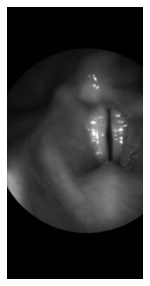

In [17]:
fnames_train = get_image_files(path_train_img)
lbl_names_train = get_image_files(path_train_lbl)

# open and show image
img_f = fnames_train[5]
print(img_f)

img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [18]:
print(get_y_fn(img_f))

/home/ec2-user/SageMaker/data/Labels/training/28598.png


<AxesSubplot:>

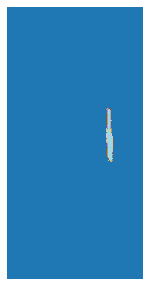

In [19]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [20]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [21]:
height = 512
width = 256
bs = 8

In [38]:
# Add values 'Original' and Segmentation
!touch /home/ec2-user/SageMaker/data/codes.txt

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Original', 'Segmentation'], dtype='<U12')

Setting-up type transforms pipelines
Found 55750 items
2 datasets of sizes 52963,2787
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/ec2-user/SageMaker/data/Images/training/5889.png
    applying PILBase.create gives
      PILImage mode=RGB size=256x512
  Pipeline: <lambda> -> PILBase.create
    starting from
      /home/ec2-user/SageMaker/data/Images/training/5889.png
    applying <lambda> gives
      /home/ec2-user/SageMaker/data/Labels/training/5889.png
    applying PILBase.create gives
      PILMask mode=L size=256x512

Final sample: (PILImage mode=RGB size=256x512, PILMask mode=L size=256x512)


Found 55750 items
2 datasets of sizes 52963,2787
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (256, 512), 'method': 'crop', 'pad_mode': 'refl

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


  Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (256, 512), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
    starting from
      (PILImage mode=RGB size=256x512, PILMask mode=L size=256x512)
    applying AddMaskCodes gives
      (PILImage mode=RGB size=256x512, PILMask mode=L size=256x512)
    applying TargetMaskConvertTransform gives
      (PILImage mode=RGB size=256x512, PILMask mode=L size=256x512)
    applying Resize -- {'size': (256, 512), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} gives
      (PILImage mode=RGB size=256x512, PILMask mode=L size=256x512)
    applying ToTensor gives
      (TensorImage of size 3x512x256, TensorMask of size 512x256)

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]]

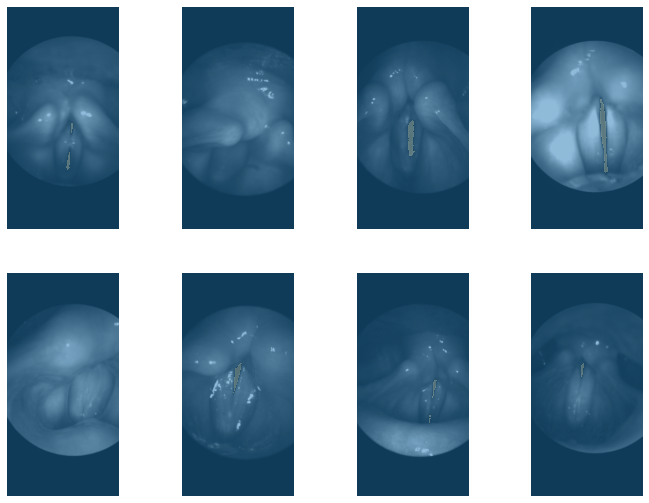

In [22]:
train = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files, folders=[train_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.05, seed=2021),
                   item_tfms=[Resize((height, width)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
train.summary(path_images)
dls = train.dataloaders(path_images, bs=bs)
dls.show_batch(vmin=0, vmax=1, figsize=(12, 9))

In [22]:
%cd /home/ec2-user/SageMaker

/home/ec2-user/SageMaker


In [28]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[Dice(), JaccardCoeff()],wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

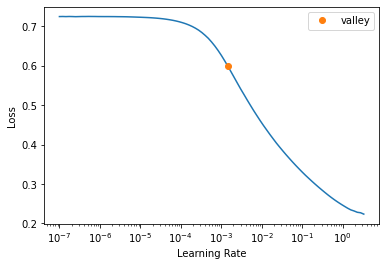

In [43]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.004134,0.003344,0.909026,0.833225,21:58
1,0.002973,0.002750,0.924982,0.860434,22:15
2,0.003169,0.003059,0.911953,0.838156,21:47
3,0.002514,0.002416,0.930710,0.870400,22:10
4,0.001924,0.001928,0.946657,0.898717,22:04
5,0.001673,0.001705,0.950801,0.906217,21:49
6,0.001468,0.001601,0.953648,0.911403,21:52
7,0.001418,0.001499,0.955745,0.915241,22:06
8,0.001330,0.001419,0.958261,0.919867,22:17
9,0.001355,0.001408,0.958521,0.920346,22:07


Better model found at epoch 0 with valid_loss value: 0.003343928838148713.


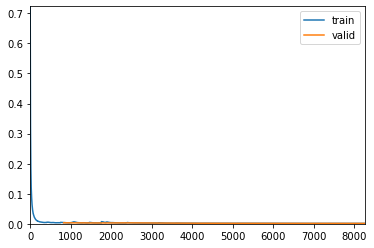

Better model found at epoch 1 with valid_loss value: 0.0027498137205839157.
Better model found at epoch 3 with valid_loss value: 0.002415602095425129.
Better model found at epoch 4 with valid_loss value: 0.0019283241126686335.
Better model found at epoch 5 with valid_loss value: 0.0017053582705557346.
Better model found at epoch 6 with valid_loss value: 0.0016011047409847379.
Better model found at epoch 7 with valid_loss value: 0.00149903679266572.
Better model found at epoch 8 with valid_loss value: 0.001418683328665793.
Better model found at epoch 9 with valid_loss value: 0.0014084837166592479.


In [44]:
fname="deeplabv3-segmentron-resnet50-train-no-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training, comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training, comp=comp_training, every_epoch=False, fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-3, 3e-2), cbs=callbacksFitBeforeUnfreeze)

In [25]:
learn.load(MODELS_PATH/"deeplabv3-segmentron-resnet50-train-no-data-augmentation-before-unfreeze-WD-2-best")
learn.validate()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.0014084933791309595,0.9585213371563024,0.9203465912005485]

Recorder

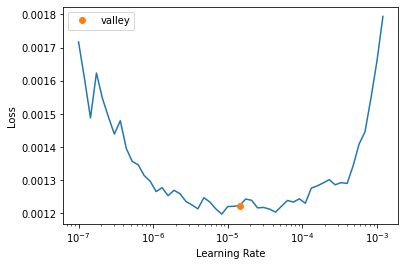

In [26]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.001310,0.001409,0.958752,0.920771,25:04
1,0.001365,0.001459,0.957165,0.917850,25:19
2,0.001336,0.001445,0.957277,0.918054,25:20


Better model found at epoch 0 with valid_loss value: 0.0014088648604229093.


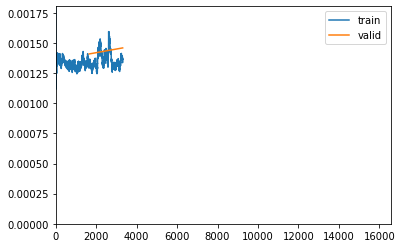

No improvement since epoch 0: early stopping


In [27]:
fname="deeplabv3-segmentron-resnet50-train-no-data-augmentation-after-unfreeze-WD-2-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training, comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training, comp=comp_training, every_epoch=False, fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-5, 7e-5),cbs=callbacksFitAfterUnfreeze)

In [29]:
%cd /home/ec2-user/SageMaker

/home/ec2-user/SageMaker


In [38]:
learn.load(MODELS_PATH/"deeplabv3-segmentron-resnet50-train-no-data-augmentation-after-unfreeze-WD-2-best")
learn.validate()

(#3) [0.0014088877942413092,0.9587533580867609,0.9207745019230977]

Recorder

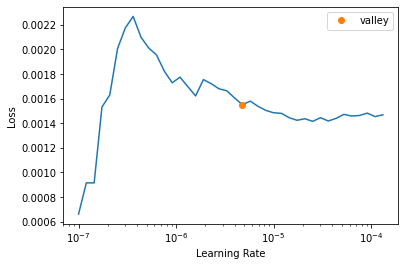

In [39]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.001333,0.001512,0.955687,0.915136,28:09
1,0.001336,0.001477,0.956541,0.916703,28:28
2,0.001351,0.001440,0.957716,0.918863,28:02
3,0.001247,0.001393,0.958929,0.921099,28:25
4,0.001327,0.001411,0.958538,0.920377,27:54
5,0.001318,0.001353,0.960705,0.924381,28:17
6,0.001202,0.001332,0.960996,0.924920,28:07
7,0.001247,0.001316,0.961268,0.925424,28:28
8,0.001106,0.001308,0.961634,0.926103,28:11
9,0.001251,0.001329,0.960987,0.924905,28:33


Better model found at epoch 0 with valid_loss value: 0.0015118675073608756.


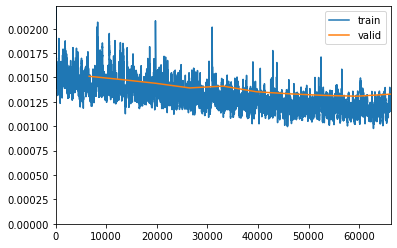

Better model found at epoch 1 with valid_loss value: 0.0014771849382668734.
Better model found at epoch 2 with valid_loss value: 0.0014397484483197331.
Better model found at epoch 3 with valid_loss value: 0.0013926036190241575.
Better model found at epoch 5 with valid_loss value: 0.001353114959783852.
Better model found at epoch 6 with valid_loss value: 0.0013319171266630292.
Better model found at epoch 7 with valid_loss value: 0.0013162529794499278.
Better model found at epoch 8 with valid_loss value: 0.001307820901274681.


In [40]:
fname="deeplabv3-segmentron-resnet50-train-no-data-augmentation-after-unfreeze-WD-2-best-part-2"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training, comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training, comp=comp_training, every_epoch=False, fname=fname)  
]
learn.fit_one_cycle(10, slice(7e-6, 4e-5),cbs=callbacksFitAfterUnfreeze)

Setting-up type transforms pipelines
Found 59250 items
2 datasets of sizes 55750,3500
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/ec2-user/SageMaker/data/Images/training/9226.png
    applying PILBase.create gives
      PILImage mode=RGB size=256x512
  Pipeline: <lambda> -> PILBase.create
    starting from
      /home/ec2-user/SageMaker/data/Images/training/9226.png
    applying <lambda> gives
      /home/ec2-user/SageMaker/data/Labels/training/9226.png
    applying PILBase.create gives
      PILMask mode=L size=256x512

Final sample: (PILImage mode=RGB size=256x512, PILMask mode=L size=256x512)


Found 59250 items
2 datasets of sizes 55750,3500
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (256, 512), 'method': 'crop', 'pad_mode': 'refl

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)



No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
    starting from
      (TensorImage of size 4x3x512x256, TensorMask of size 4x512x256)
    applying IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} gives
      (TensorImage of size 4x3x512x256, TensorMask of size 4x512x256)
    applying Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)} gives
      (TensorImage of size 4x3x512x256, TensorMask of size 4x512x256)


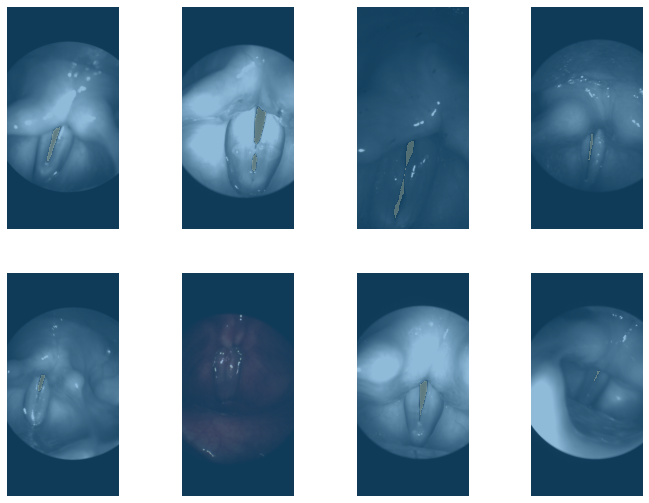

In [23]:
train = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files, folders=[train_name, test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((height, width)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
train.summary(path_images)
dls = train.dataloaders(path_images, bs=bs)
dls.show_batch(vmin=0, vmax=1, figsize=(12, 9))

In [33]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

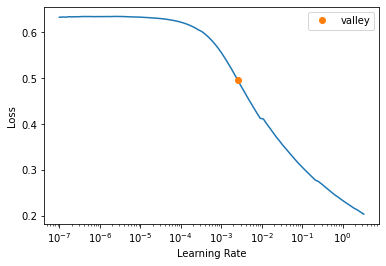

In [43]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.003887,0.024392,0.729909,0.574690,24:56
1,0.006231,0.008416,0.894937,0.809852,25:12
2,0.004358,0.005944,0.913533,0.840828,25:13
3,0.006344,0.006724,0.910778,0.836173,25:09
4,0.002703,0.005699,0.920294,0.852356,25:16
5,0.002202,0.006007,0.916213,0.845381,24:48
6,0.001970,0.006341,0.917546,0.847653,25:16


Better model found at epoch 0 with dice value: 0.729908674116754.


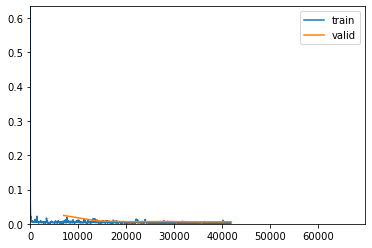

Better model found at epoch 1 with dice value: 0.8949369680834572.
Better model found at epoch 2 with dice value: 0.9135325518828754.
Better model found at epoch 4 with dice value: 0.92029394444217.
No improvement since epoch 4: early stopping


In [44]:
fname="deeplabv3-segmentron-resnet50-train-no-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating, comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating, comp=comp_evaluating, every_epoch=False, fname=fname)  
]
learn.fit_one_cycle(10, slice(5e-3, 5e-2), cbs=callbacksFitBeforeUnfreeze)

In [45]:
learn.load("deeplabv3-segmentron-resnet50-train-no-data-augmentation-before-unfreeze-best")
learn.validate()

(#3) [0.005698648281395435,0.92029394444217,0.8523560090312732]

In [47]:
aux = learn.model
aux = aux.cpu()

traced_cell = torch.jit.script(aux)
traced_cell.save("models/deeplabv3+-dataset1-data-augmentation.pth")

Recorder

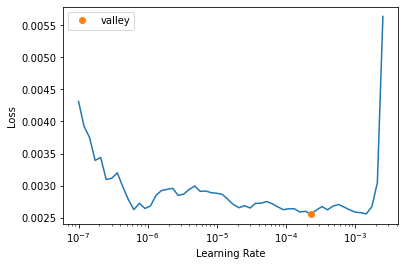

In [49]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.002468,0.005719,0.921822,0.854981,29:22
1,0.002324,0.006877,0.907117,0.830022,29:52
2,0.002234,0.005864,0.918703,0.849630,29:41


Better model found at epoch 0 with dice value: 0.9218218311482814.


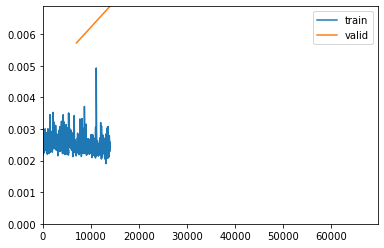

No improvement since epoch 0: early stopping


In [50]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating, comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating, comp=comp_evaluating, every_epoch=False, fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-6, 8e-6), cbs=callbacksFitAfterUnfreeze)

In [34]:
learn.load("deeplabv3-segmentron-resnet50-manual-data-augmentation-after-unfreeze-best")
learn.validate()

(#3) [0.005950549151748419,0.9211034033128935,0.8537457677976392]

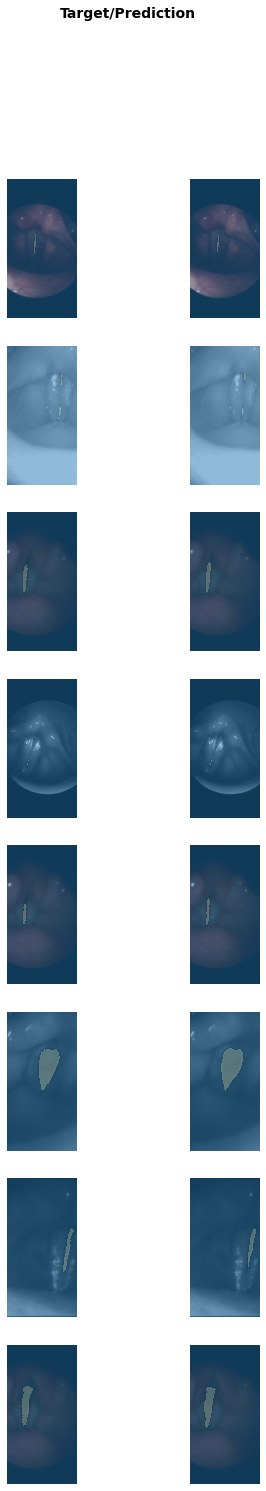

In [26]:
learn.show_results(vmin=0, vmax=1) # show results

Setting-up type transforms pipelines
Found 59250 items
2 datasets of sizes 55750,3500
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/ec2-user/SageMaker/data/Images/training/9226.png
    applying PILBase.create gives
      PILImage mode=RGB size=256x512
  Pipeline: <lambda> -> PILBase.create
    starting from
      /home/ec2-user/SageMaker/data/Images/training/9226.png
    applying <lambda> gives
      /home/ec2-user/SageMaker/data/Labels/training/9226.png
    applying PILBase.create gives
      PILMask mode=L size=256x512

Final sample: (PILImage mode=RGB size=256x512, PILMask mode=L size=256x512)


Found 59250 items
2 datasets of sizes 55750,3500
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (256, 51

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)



No before_batch transform to apply

Collating items in a batch

Applying batch_tfms to the batch built
  Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}
    starting from
      (TensorImage of size 4x3x512x256, TensorMask of size 4x512x256)
    applying IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} gives
      (TensorImage of size 4x3x512x256, TensorMask of size 4x512x256)
    applying Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)} gives
      (TensorImage of size 4x3x512x256, TensorMask of size 4x512x256)


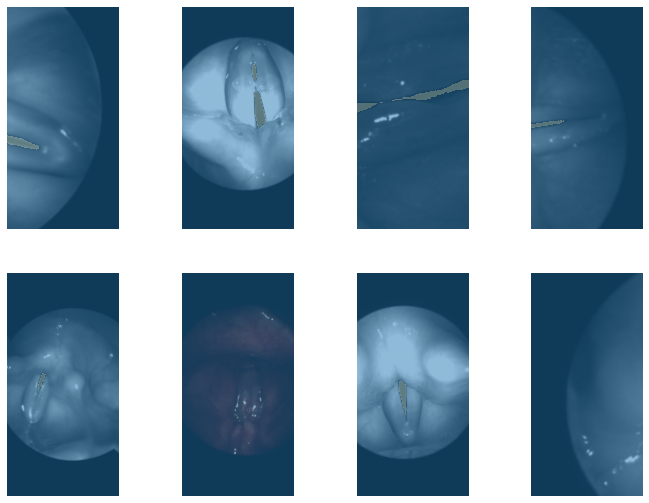

In [23]:
train = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files, folders=[train_name, test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((height, width)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
train.summary(path_images)
dls = train.dataloaders(path_images, bs=bs)
dls.show_batch(vmin=0, vmax=1, figsize=(12, 9))

In [31]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet50", 
                                 metrics=[Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

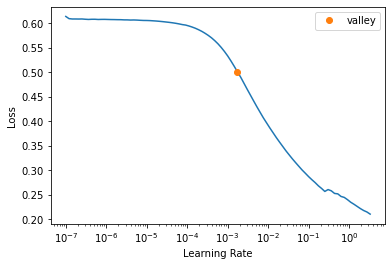

In [32]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.004861,0.015421,0.857444,0.750461,25:15
1,0.008736,0.021063,0.696051,0.533802,25:21
2,0.004244,0.014467,0.860613,0.755330,24:47
3,0.007374,0.008500,0.889338,0.800728,25:17
4,0.005338,0.009472,0.884885,0.793537,25:07
5,0.009457,0.013262,0.874207,0.776526,25:18


Better model found at epoch 0 with dice value: 0.8574440694791834.


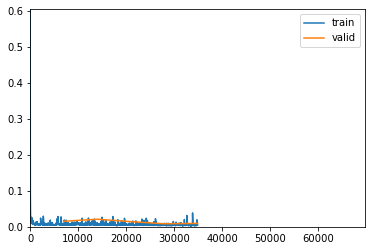

Better model found at epoch 2 with dice value: 0.8606132825195674.
No improvement since epoch 3: early stopping


In [ ]:
fname="deeplabv3-segmentron-resnet50-train-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating, comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating, comp=comp_evaluating, every_epoch=False, fname=fname)  
]
learn.fit_one_cycle(10, slice(3e-3, 3e-2), cbs=callbacksFitBeforeUnfreeze)

In [34]:
learn.load("deeplabv3-segmentron-resnet50-train-data-augmentation-before-unfreeze-best")
learn.validate()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.008500473573803902,0.8893383727744686,0.8007284585819936]

In [35]:
aux = learn.model
aux = aux.cpu()

traced_cell = torch.jit.script(aux)
traced_cell.save("models/deeplabv3+-dataset1-data-augmentation.pth")

Recorder

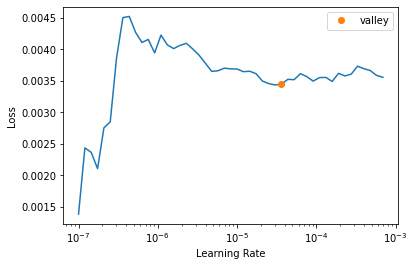

In [36]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.006142,0.008442,0.891252,0.803837,29:37
1,0.004461,0.008834,0.891058,0.803520,29:41
2,0.004394,0.015141,0.865160,0.762362,29:53


Better model found at epoch 0 with dice value: 0.8912522110486972.


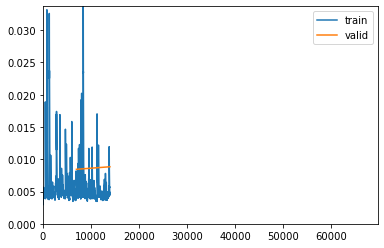

No improvement since epoch 0: early stopping


In [37]:
fname="deeplabv3-segmentron-resnet50-manual-data-augmentation-after-unfreeze-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating, comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating, comp=comp_evaluating, every_epoch=False, fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-7, 2e-7), cbs=callbacksFitAfterUnfreeze)

In [38]:
learn.load("deeplabv3-segmentron-resnet50-manual-data-augmentation-after-unfreeze-best")
learn.validate()

(#3) [0.008441881276667118,0.8912522110486972,0.8038367426118419]

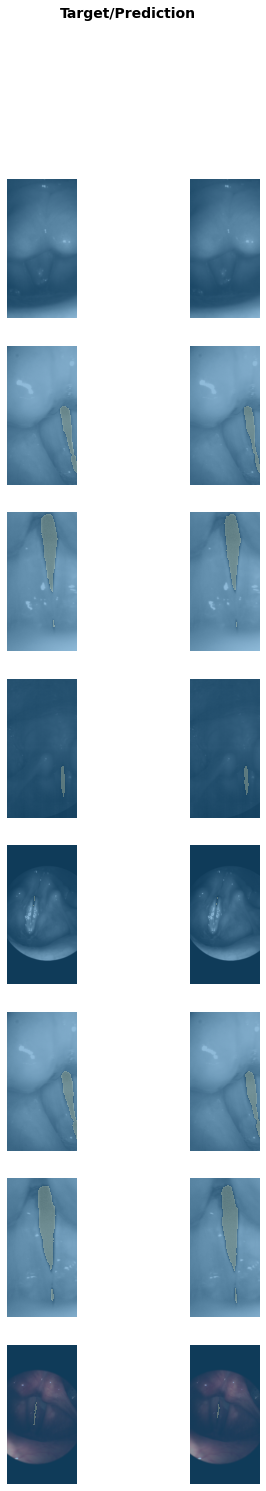

In [39]:
learn.show_results(vmin=0, vmax=1) # show results

In [24]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="deeplabv3+", backbone_name="resnet101", 
                                 metrics=[Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=segmentron_splitter).to_fp16()
learn.freeze() # Freezing the backbone

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Recorder

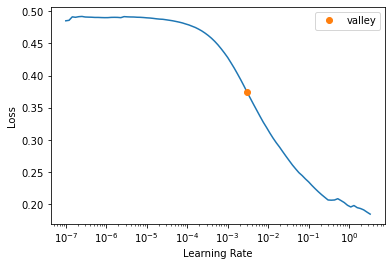

In [25]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.011048,0.019783,0.784638,0.645600,31:55
1,0.007490,0.013763,0.860438,0.755060,31:47
2,0.005776,0.023808,0.758164,0.610519,31:54
3,0.006446,0.020245,0.858651,0.752313,31:42


Better model found at epoch 0 with dice value: 0.784638151280134.


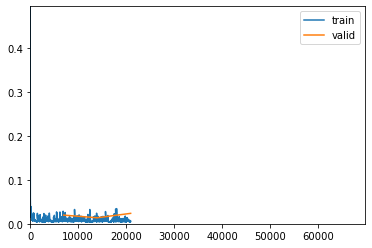

Better model found at epoch 1 with dice value: 0.8604378932164398.
No improvement since epoch 1: early stopping


In [27]:
fname = "deeplabv3-segmentron-resnet101-train-data-augmentation-before-unfreeze-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating, comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating, comp=comp_evaluating, every_epoch=False, fname=fname)  
]
learn.fit_one_cycle(10, slice(5e-3, 5e-2), cbs=callbacksFitBeforeUnfreeze)

In [28]:
learn.load(fname)
learn.validate()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.01376332063227892,0.8604378932164398,0.7550601130859337]

In [41]:
def hrnet_splitter(model):
    return [params(model.backbone), params(model.head)]

In [42]:
train_name = "training"

In [43]:
path_train_img = path_images/train_name
path_train_lbl = path_labels/train_name

/home/ec2-user/SageMaker/data/Images/training/45772.png


<AxesSubplot:>

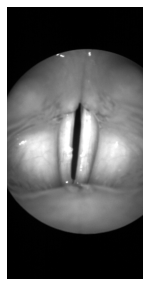

In [44]:
fnames_train = get_image_files(path_train_img)
lbl_names_train = get_image_files(path_train_lbl)

# open and show image
img_f = fnames_train[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [45]:
print(get_y_fn(img_f))

/home/ec2-user/SageMaker/data/Labels/training/45772.png


<AxesSubplot:>

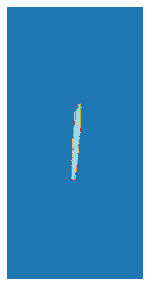

In [46]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [47]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [48]:
height = 512
width = 256
bs = 8

Setting-up type transforms pipelines
Found 59250 items
2 datasets of sizes 55750,3500
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/ec2-user/SageMaker/data/Images/training/9226.png
    applying PILBase.create gives
      PILImage mode=RGB size=256x512
  Pipeline: <lambda> -> PILBase.create
    starting from
      /home/ec2-user/SageMaker/data/Images/training/9226.png
    applying <lambda> gives
      /home/ec2-user/SageMaker/data/Labels/training/9226.png
    applying PILBase.create gives
      PILMask mode=L size=256x512

Final sample: (PILImage mode=RGB size=256x512, PILMask mode=L size=256x512)


Found 59250 items
2 datasets of sizes 55750,3500
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (256, 51

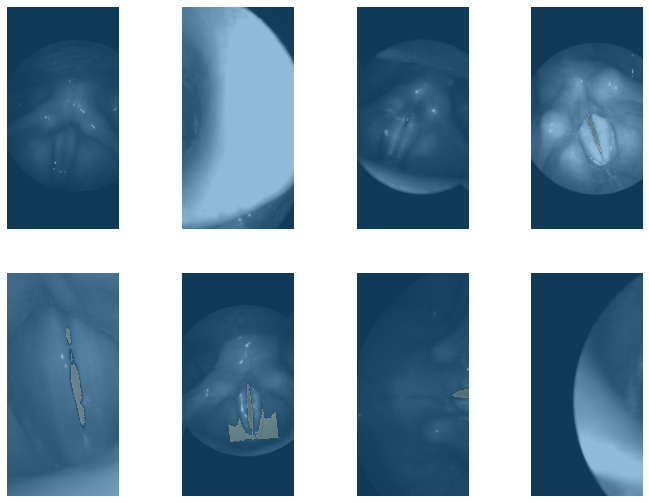

In [49]:
train = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files, folders=[train_name, test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((height, width)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
train.summary(path_images)
dls = train.dataloaders(path_images, bs=bs)
dls.show_batch(vmin=0, vmax=1, figsize=(12, 9))

In [64]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w30", 
                                 metrics=[Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True).to_fp16()
learn.freeze() # Freezing the backbone

Recorder

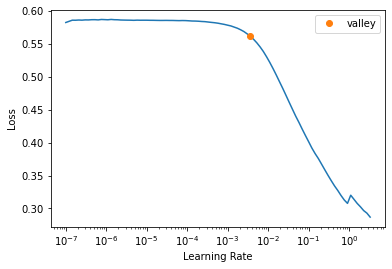

In [49]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.006554,0.015975,0.795503,0.660444,43:40
1,0.008163,0.018071,0.757613,0.609805,43:37
2,0.003296,0.009009,0.883086,0.790648,43:38
3,0.006520,0.007941,0.889450,0.800909,43:50
4,0.003405,0.008853,0.883535,0.791368,43:52
5,0.003456,0.006241,0.912634,0.839307,43:49
6,0.003728,0.005974,0.916051,0.845106,43:59
7,0.002753,0.005650,0.922859,0.856767,43:57
8,0.003438,0.005958,0.922363,0.855913,43:57
9,0.003136,0.005614,0.925605,0.861512,44:07


Better model found at epoch 0 with valid_loss value: 0.01597469672560692.


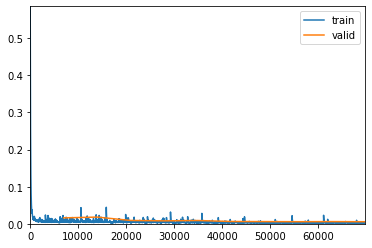

Better model found at epoch 2 with valid_loss value: 0.009009132161736488.
Better model found at epoch 3 with valid_loss value: 0.007940667681396008.
Better model found at epoch 5 with valid_loss value: 0.006240553222596645.
Better model found at epoch 6 with valid_loss value: 0.005974241532385349.
Better model found at epoch 7 with valid_loss value: 0.005649622995406389.
Better model found at epoch 9 with valid_loss value: 0.005613578483462334.


In [ ]:
fname = "hrnet-train-data-augmentation-before-unfreeze-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training, comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training, comp=comp_training, every_epoch=False, fname=fname)  
]
learn.fit_one_cycle(10, slice(5e-3, 5e-2), cbs=callbacksFitBeforeUnfreeze)

In [ ]:
learn.load(fname)
learn.validate()